# What is the purpose of this project?
The purpose of this project is to measure the effects of gravity on an ideal gas. We will do this by measuring the change in densities in different sections of the box representing the change in density in relation to altitude. 

Let's make a plan to implement.

## Steps
1.) Set up box containing the ideal gas

2.) Create the bounds for the segments of the box used to measure the density of the particles

3.) Run the simulation and record the average density of the segments in the box

4.) Apply gravity to the simulation

5.) Run the simulation and find the new densities 




## Challenges
Accurately demonstrate the differences in density with gravity and change in y coordinates.

Validating the model; how do i know my model is correct?


# Let's Import code from our ideal gas model

In [1]:
from vpython import *
import numpy as np
import random as rand
import matplotlib.pyplot as plt

<IPython.core.display.Javascript object>

In [2]:
def check_collisions():
    """Determine all pairs of colliding spheres in the global particles[] list. 
        
    """
    collided_pairs = [] #a list of pairs of spheres that are overlapping
    
    for i in range(N):
        for j in range(i+1,N): #start at i+1 to avoid double counting and to avoid self-collision
            d = mag(particles[i].pos - particles[j].pos)
            if d < 2*R:
                collided_pairs.append([i,j])            
    
    return collided_pairs

In [3]:
def calc_collision(i,j):
    """Calculate new velocity, momentum, and position of pairs of colliding spheres in the global particles[] list. 

    Keyword arguments:
    i -- index of one colliding sphere
    j -- index of second colliding sphere

    """

    global particles
    
    r1 = particles[i].pos
    r2 = particles[j].pos
    v1 = particles[i].v
    v2 = particles[j].v
    p1 = m*v1
    p2 = m*v2
    v1i = v1
    v2i = v2
    
    #transform to reference frame of particle 1
    v2rel = v2 - v1
    r2rel = r2 - r1
    
    #find time when collision ocurred
    dx = dot(r2rel, hat(v2rel))
    dy = mag(cross(r2rel, hat(v2rel)))
    if (dy>2*R): return #fixes math domain error
    alpha = asin(dy/2/R)
    d = 2*R*cos(alpha) + dx
    deltat = d/mag(v2rel)
    
    #move particles backward in time to their locations at the collision
    particles[i].pos = particles[i].pos - particles[i].v*deltat
    particles[j].pos = particles[j].pos - particles[j].v*deltat
    
    #calculate new momenta using CM reference frame
    r1 = particles[i].pos
    r2 = particles[j].pos
    M = 2*m #total mass
    ptot = p1+p2 #total momentum
    vcm = ptot/M
    v1rel = v1 - vcm
    v2rel = v2 - vcm
    p1rel = m*v1rel
    p2rel = m*v2rel
    r = r2 - r1
    p1rel = p1rel - 2*dot(p1rel,hat(r))*hat(r)
    p2rel = p2rel - 2*dot(p2rel,hat(r))*hat(r)
    v1rel = p1rel/m
    v2rel = p2rel/m
    v1 = vcm + v1rel
    v2 = vcm + v2rel
    p1 = m*v1
    p2 = m*v2
    particles[i].v = v1
    particles[j].v = v2

    #move particles forward in time to their locations at the end of the time step
    particles[i].pos = particles[i].pos + particles[i].v*deltat
    particles[j].pos = particles[j].pos + particles[j].v*deltat
    





# Lets first create a scene with an ideal gas in a box unaffected by gravity and measure the density.

We will measure density by splitting the box into three imaginary segments.
Each segment is the same length and width as the box and one third of its height.

The first segment will start at the top of the box and go 1/3rd of the way down.

The second segment starts at the bottom of the first and goes down another 1/3rd.

The last segment will start below the second and will contain the remaining 1/3rd of the box at the bottom.

The segments will be more useful later when gravity is applied in order to measure it's effects. Each segment is seperated by a yellow box for visualizing the simulation only; they do not affect the simulation mathmatically.

In [4]:
scene = canvas(title="Density of ideal gases in box unaffected by gravity")

#constants
m = 2.6566962e-26 #mass of atom in kg #old value 1.7e-27
R = 1.52e-10 #radius of atom in m  #old value 0.5e-10
L = 40*R #length of box in m
thick = L/100 #thickness of box wall in m
k = 1.4e-23 #boltzmann constant
T = 288 #temp in K  #old value 300
s =  np.sqrt(2*3/2*k*T/m) #initial speed
Volume = 4/3*pi*R**3 # volume of particle| expected value is 5.23598e-31
segmentVolume = L*L*(L*.3333)  #volume of each segment

#segment boundaries and starting amounts of particles in each boundary
topBottomBound = L/2 - L*.3333
bottomUpperBound = -L/2 + L*.3333
topAmount = 0
midAmount = 0
botAmount = 0

print("Please wait until the end of the simulation in order to fully understand the data and its interactions")
print("Volume of particle(expected value:5.23598e-31)",Volume)  #check that values are expected
print("Volume of each segment",segmentVolume)


#visual objects
Lwall = box(pos = vec(-L/2, 0, 0), size = vec(thick, L, L), color=color.white)
Rwall = box(pos = vec(L/2, 0, 0), size = vec(thick, L, L), color=color.white)
Bwall = box(pos = vec(0, -L/2, 0), size = vec(L, thick, L), color=color.white)
Twall = box(pos = vec(0, L/2, 0), size = vec(L, thick, L), color=color.white)
Zwall = box(pos = vec(0, 0, -L/2), size = vec(L, L, thick), color=color.white)

#segment indicators
topseg = box(pos = vec(0,topBottomBound,0), size = vec(L,thick/2,L), color=color.yellow)
botseg = box(pos = vec(0,bottomUpperBound,0), size = vec(L,thick/2,L), color=color.yellow)

particles = [] #list of particles

N=200 #number of particles

#create particles
for i in range(N):
    if i==0:
        particle = sphere(pos = L/2*vec(rand.uniform(-0.9,0.9),rand.uniform(-0.9,0.9),rand.uniform(-0.9,0.9)), radius = R, color = color.cyan, make_trail=True, retain=20, trail_radius=0.3*R)
    else:
        particle = sphere(pos = L/2*vec(rand.uniform(-0.9,0.9),rand.uniform(-0.9,0.9),rand.uniform(-0.9,0.9)), radius = R, color = color.red)

    #initial velocity
    particle.v = s*hat(vec(rand.uniform(-1,1), rand.uniform(-1,1), rand.uniform(-1,1)))
    particle.p = m*particle.v

    particles.append(particle)

#check for collisions and rerandomize positions of particles that are collided
collided_pairs = check_collisions()
while len(collided_pairs)!=0:
    for pair in collided_pairs:
        particles[pair[0]].pos = L/2*vec(rand.uniform(-1,1),rand.uniform(-1,1),rand.uniform(-1,1))
        particles[pair[1]].pos = L/2*vec(rand.uniform(-1,1),rand.uniform(-1,1),rand.uniform(-1,1))
        #print("finding new positions please wait...")
    collided_pairs = check_collisions()

#time
t = 0
dt = R/s/10



#Counting particles in each segment
for particle in particles:
    if particle.pos.y > topBottomBound:  #checks if the y pos of the particle is located in the upper segment 
        topAmount +=1
        
    elif particle.pos.y < bottomUpperBound:  #checks if the y pos of the particle is located in the lower segment 
        botAmount +=1
        
    else:
        midAmount +=1
        
#find out starting densities in g/m^3
topDensity = ((topAmount*Volume)/segmentVolume)
midDensity = ((midAmount*Volume)/segmentVolume)
botDensity = ((botAmount*Volume)/segmentVolume)

print("starting amount of particles in top segment",topAmount)
print("starting amount of particles in middle segment",midAmount)
print("starting amount of particles in bottom segment",botAmount,"\n")

print("Starting top segment Density {0:.4} kg/m^3".format(topDensity))
print("Starting mid segment Density {0:.4} kg/m^3".format(midDensity))
print("Starting bot segment Density {0:.4} kg/m^3".format(botDensity),"\n")



#evolution
scene.pause()

Nsteps = 1e4 #number of time steps for the loop
while t < Nsteps*dt:
    rate(1000) #sets number of loops per second in order to slow down or speed up visualization
    
    
    
    #update position of each particle
    for particle in particles:
        particle.pos = particle.pos + particle.v*dt 
        
    #handle collisions of particles with each other
    collided_pairs = check_collisions()
    for pair in collided_pairs:
        i = pair[0]
        j = pair[1]
        calc_collision(i,j)
    
    #handle collision with walls
    for particle in particles:
        if particle.pos.x > L/2:
            particle.v.x = - abs(particle.v.x)
            particle.p = m*particle.v
        elif particle.pos.x < -L/2:
            particle.v.x = abs(particle.v.x)
            particle.p = m*particle.v

        if particle.pos.y > L/2:
            particle.v.y = - abs(particle.v.y)
            particle.p = m*particle.v
        elif particle.pos.y < -L/2:
            particle.v.y = abs(particle.v.y)
            particle.p = m*particle.v

        if particle.pos.z > L/2:
            particle.v.z = - abs(particle.v.z)
            particle.p = m*particle.v
        elif particle.pos.z < -L/2:
            particle.v.z = abs(particle.v.z)
            particle.p = m*particle.v
            
            

            
     
    t = t + dt

#reset the counts
topAmount = 0
midAmount = 0
botAmount = 0

#Counting particles in each segment
for particle in particles:
    if particle.pos.y > topBottomBound:  #checks if the y pos of the particle is located in the upper segment 
        topAmount +=1
        
    elif particle.pos.y < bottomUpperBound:  #checks if the y pos of the particle is located in the lower segment 
        botAmount +=1       
    else:
        midAmount +=1
        
print("ending amount of particles in top segment",topAmount)
print("ending amount of particles in middle segment",midAmount)
print("ending amount of particles in bottom segment",botAmount,"\n")  

topDensity = ((topAmount*Volume)/segmentVolume)
midDensity = ((midAmount*Volume)/segmentVolume)
botDensity = ((botAmount*Volume)/segmentVolume)


print("Ending top segment Density {0:.4} kg/m^3".format(topDensity))
print("Ending middle segment Density {0:.4} kg/m^3".format(midDensity))
print("Ending bottom segment Density {0:.4} kg/m^3".format(botDensity),"\n")

<IPython.core.display.Javascript object>

Please wait until the end of the simulation in order to fully understand the data and its interactions
Volume of particle(expected value:5.23598e-31) 1.4710226951490482e-29
Volume of each segment 7.491107880959997e-26


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

starting amount of particles in top segment 78
starting amount of particles in middle segment 72
starting amount of particles in bottom segment 50 

Starting top segment Density 0.01532 kg/m^3
Starting mid segment Density 0.01414 kg/m^3
Starting bot segment Density 0.009818 kg/m^3 



KeyboardInterrupt: 

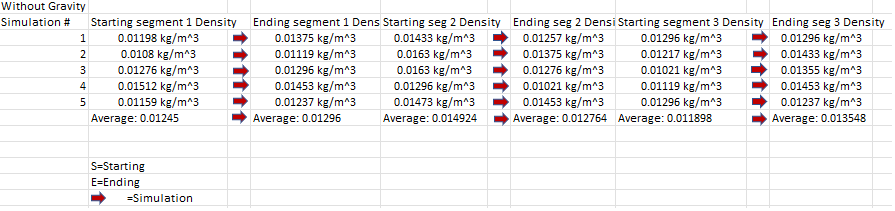

# What information can we grab from this?

As we can see the density at the start and the end of the simulation are very similar. Therefore we can infer that in a box without gravity the density of an ideal gas is randomly distributed.



My hypothesis is that once we add gravtiy there will be a measurable difference in the amount of particles in each segment and their densities.

Lets add gravity to the simulation and measure its effects.

He is a professional rendition of it's predicted effects. More particles at the bottom and less towards the top.

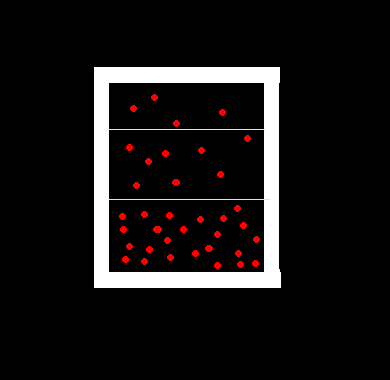

In [13]:
#Gravity 
m = 3.6863964e-25
FNet = vec(0,-9.8*m,0) #force of gravity

#Since we have no other forces acting upon the particles we can infer that FNet = FGrav



Now let's rerun the simultation 

In [5]:
scene = canvas(title="Density of ideal gases in box affected by gravity")

#constants
m = 2.6566962e-26 #mass of atom in kg #old value 1.7e-27
R = 1.52e-10 #radius of atom in m  #old value 0.5e-10
L = 40*R #length of box in m
thick = L/100 #thickness of box wall in m
k = 1.4e-23 #boltzmann constant
T = 288 #temp in K  #old value 300
s =  np.sqrt(2*3/2*k*T/m) #initial speed
Volume = 4/3*pi*R**3 # volume of particle| expected value is 5.23598e-31
segmentVolume = L*L*(L*.3333)  #volume of each segment

#segment boundaries and starting amounts of particles in each boundary
topBottomBound = L/2 - L*.3333
bottomUpperBound = -L/2 + L*.3333
topAmount = 0
midAmount = 0
botAmount = 0

print("Please wait until the end of the simulation in order to fully understand the data and its interactions")
print("Volume of particle(expected value:5.23598e-31)",Volume)  #check that values are expected
print("Volume of each segment",segmentVolume)


#visual objects
Lwall = box(pos = vec(-L/2, 0, 0), size = vec(thick, L, L), color=color.white)
Rwall = box(pos = vec(L/2, 0, 0), size = vec(thick, L, L), color=color.white)
Bwall = box(pos = vec(0, -L/2, 0), size = vec(L, thick, L), color=color.white)
Twall = box(pos = vec(0, L/2, 0), size = vec(L, thick, L), color=color.white)
Zwall = box(pos = vec(0, 0, -L/2), size = vec(L, L, thick), color=color.white)

#segment indicators
topseg = box(pos = vec(0,topBottomBound,0), size = vec(L,thick/2,L), color=color.yellow)
botseg = box(pos = vec(0,bottomUpperBound,0), size = vec(L,thick/2,L), color=color.yellow)

particles = [] #list of particles

N=200 #number of particles

#create particles
for i in range(N):
    if i==0:
        particle = sphere(pos = L/2*vec(rand.uniform(-0.9,0.9),rand.uniform(-0.9,0.9),rand.uniform(-0.9,0.9)), radius = R, color = color.cyan, make_trail=True, retain=20, trail_radius=0.3*R)
    else:
        particle = sphere(pos = L/2*vec(rand.uniform(-0.9,0.9),rand.uniform(-0.9,0.9),rand.uniform(-0.9,0.9)), radius = R, color = color.red)

    #initial velocity
    particle.v = s*hat(vec(rand.uniform(-1,1), rand.uniform(-1,1), rand.uniform(-1,1)))
    particle.p = m*particle.v

    particles.append(particle)

#check for collisions and rerandomize positions of particles that are collided
collided_pairs = check_collisions()
while len(collided_pairs)!=0:
    for pair in collided_pairs:
        particles[pair[0]].pos = L/2*vec(rand.uniform(-1,1),rand.uniform(-1,1),rand.uniform(-1,1))
        particles[pair[1]].pos = L/2*vec(rand.uniform(-1,1),rand.uniform(-1,1),rand.uniform(-1,1))
        #print("finding new positions please wait...")
    collided_pairs = check_collisions()

#time
t = 0
dt = R/s/10



#Counting particles in each segment
for particle in particles:
    if particle.pos.y > topBottomBound:  #checks if the y pos of the particle is located in the upper segment 
        topAmount +=1
        
    elif particle.pos.y < bottomUpperBound:  #checks if the y pos of the particle is located in the lower segment 
        botAmount +=1
        
    else:
        midAmount +=1
        
#find out starting densities in g/m^3
topDensity = ((topAmount*Volume)/segmentVolume)
midDensity = ((midAmount*Volume)/segmentVolume)
botDensity = ((botAmount*Volume)/segmentVolume)

print("Starting amount of particles in top segment",topAmount)
print("Starting amount of particles in middle segment",midAmount)
print("Starting amount of particles in bottom segment",botAmount,"\n")

print("Starting top segment Density {0:.4} kg/m^3".format(topDensity))
print("Starting mid segment Density {0:.4} kg/m^3".format(midDensity))
print("Starting bot segment Density {0:.4} kg/m^3".format(botDensity),"\n")



#evolution
scene.pause()

Nsteps = 1e4 #number of time steps for the loop
while t < Nsteps*dt:
    rate(1000) #sets number of loops per second in order to slow down or speed up visualization
    
    
    
    #update position of each particle
    for particle in particles:
        particle.p = particle.p + (FNet*dt)
        particle.v = particle.p/m
        particle.pos = particle.pos + particle.v*dt 
        
    #handle collisions of particles with each other
    collided_pairs = check_collisions()
    for pair in collided_pairs:
        i = pair[0]
        j = pair[1]
        calc_collision(i,j)
    
    #handle collision with walls
    for particle in particles:
        if particle.pos.x > L/2:
            particle.v.x = - abs(particle.v.x)
            particle.p = m*particle.v
        elif particle.pos.x < -L/2:
            particle.v.x = abs(particle.v.x)
            particle.p = m*particle.v

        if particle.pos.y > L/2:
            particle.v.y = - abs(particle.v.y)
            particle.p = m*particle.v
        elif particle.pos.y < -L/2:
            particle.v.y = abs(particle.v.y)
            particle.p = m*particle.v

        if particle.pos.z > L/2:
            particle.v.z = - abs(particle.v.z)
            particle.p = m*particle.v
        elif particle.pos.z < -L/2:
            particle.v.z = abs(particle.v.z)
            particle.p = m*particle.v
            
            

            
     
    t = t + dt

#reset the counts
topAmount = 0
midAmount = 0
botAmount = 0

#Counting particles in each segment
for particle in particles:
    if particle.pos.y > topBottomBound:  #checks if the y pos of the particle is located in the upper segment 
        topAmount +=1
        
    elif particle.pos.y < bottomUpperBound:  #checks if the y pos of the particle is located in the lower segment 
        botAmount +=1       
    else:
        midAmount +=1
        
print("Ending amount of particles in top segment",topAmount)
print("Ending amount of particles in middle segment",midAmount)
print("Ending amount of particles in bottom segment",botAmount,"\n")  

topDensity = ((topAmount*Volume)/segmentVolume)
midDensity = ((midAmount*Volume)/segmentVolume)
botDensity = ((botAmount*Volume)/segmentVolume)


print("Ending top segment Density {0:.4} kg/m^3".format(topDensity))
print("Ending middle segment Density {0:.4} kg/m^3".format(midDensity))
print("Ending bottom segment Density {0:.4} kg/m^3".format(botDensity))

<IPython.core.display.Javascript object>

Please wait until the end of the simulation in order to fully understand the data and its interactions
Volume of particle(expected value:5.23598e-31) 1.4710226951490482e-29
Volume of each segment 7.491107880959997e-26


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Starting amount of particles in top segment 68
Starting amount of particles in middle segment 72
Starting amount of particles in bottom segment 60 

Starting top segment Density 0.01335 kg/m^3
Starting mid segment Density 0.01414 kg/m^3
Starting bot segment Density 0.01178 kg/m^3 



KeyboardInterrupt: 

# There seems to be a problem
With Gravity, our simulation has no noticiable or measurable differences.

I hypothesise that this is because the box is relatively short and therefore cannot accurately represent a significant change in altitude. We also see there is quite a lot of empty space in the box compared to a gas in real life. 

To fix this lets make the box into a recatangle that is much taller than it is wide. Also in our simulation we are going to significantly increase the number of particles in order it to more closely match real life.

##### Important Note:
This simulation is very taxing in python and on my laptop so in order to combat this I have removed the z values for the next simulation. I belive this is the best way to be able to keep the model operating at a watchable speed and stay as accurate as possible.

In [5]:
#Gravity 
m = 3.6863964e-25 *10000
FNet = vec(0,-9.8*m,0) #force of gravity

#Since we have no other forces acting upon the particles we can infer that FNet = FGrav

In [ ]:
scene = canvas(title = "2D representation of ideal gas affected by gravity")

m = 3.6863964e-25 *10000 #the *1000000 is to help show gravity's effects in such a short time span
k = 1.4e-23 #boltzmann constant
R = 1.52e-10 *1000#radius of atom in m *1000 to make scene more visible
T=1 #temp in kelvin 288 old
D=R*2  #diameter of atom in m
L=10*D #length of box in m
H=400*D #height of box in m
W=D+D*.1 #width of box in m
thick = L/30
s =  (np.sqrt(2*3/2*k*T/m))/10 #initial speed half of original
Volume = L*W*H #volume of box in m
partVolume = 4/3*pi*R**3  #volume of particle
segVol = Volume/4 #volume of each segment (4)

#visual objects
Lwall = box(pos = vec(-L/2,0,0), size = vec(thick,H, W), color=color.white)
Rwall = box(pos = vec(L/2,0,0), size = vec(thick,H, W), color=color.white)
Bwall = box(pos = vec(0,-H/2,0), size = vec(L,thick,W), color=color.white)
Twall = box(pos = vec(0,H/2,0), size = vec(L,thick,W), color=color.white)
Zwall = box(pos = vec(0,0,-W/2), size = vec(L,H,thick), color=color.white)

#boxes from top to bottom are in following order
#TWall
#seg1
#..
#BWall
Seg1 = box(pox = vec(0,H/4,0),size =vec(L,thick/4,W), color= color.yellow)
Seg2 = box(pox = vec(0,0,0),size =vec(L,thick/4,W), color= color.yellow)
Seg3 = box(pox = vec(0,-H/4,0),size =vec(L,thick/4,W), color= color.yellow)
print("Initial speed: ",s)
print("Volume of the box in m^3: ",Volume)
print("Volume of each segment: ",segVol,"\n")

#initialize amount of particles in each segment
seg1amount =0
seg2amount =0
seg3amount =0
seg4amount =0


N=200 #number of particles
particles = [] 

#create particles
for i in range(N):
    if i==0:
        particle = sphere(pos = vec(L/2*rand.uniform(-0.9,0.9),H/2*rand.uniform(-0.9,0.9),0), radius = R, color = color.cyan, make_trail=True, retain=20, trail_radius=0.3*R)
    else:
        particle = sphere(pos = vec(L/2*rand.uniform(-0.9,0.9),H/2*rand.uniform(-0.9,0.9),0), radius = R, color = color.red)

    #initial velocity
    particle.v = s*hat(vec(rand.uniform(-1,1), rand.uniform(-1,1), 0))
    particle.p = m*particle.v

    particles.append(particle)
    
#check for collisions and rerandomize positions of particles that are collided
collided_pairs = check_collisions()
while len(collided_pairs)!=0:
    for pair in collided_pairs:
        particles[pair[0]].pos = vec(L/2*rand.uniform(-1,1),H/2*rand.uniform(-1,1),0)
        particles[pair[1]].pos = vec(L/2*rand.uniform(-1,1),H/2*rand.uniform(-1,1),0)
        collided_pairs = check_collisions()

#time
t =0
dt = R/s/10
                                     
#Counting particles in each segment
for particle in particles:
    if particle.pos.y > H/4:
        seg1amount +=1
                                     
    elif particle.pos.y < H/4 and particle.pos.y > 0:
        seg2amount +=1

    elif particle.pos.y < 0 and particle.pos.y > -H/4:
        seg3amount +=1
                                     
    elif particle.pos.y <-H/4:
        seg4amount +=1

#output amount of particles in each segment before the simulation has started 
print("Starting amount of particles in seg 1: ",seg1amount)
print("Starting amount of particles in seg 2: ",seg2amount)
print("Starting amount of particles in seg 3: ",seg3amount)
print("Starting amount of particles in seg 4: ",seg4amount,"\n")

seg1Density = ((seg1amount*partVolume)/segVol)
seg2Density = ((seg2amount*partVolume)/segVol)
seg3Density = ((seg3amount*partVolume)/segVol)
seg4Density = ((seg4amount*partVolume)/segVol)

print("Starting density of particles in seg 1 {0:.4} in kg/m^3: ".format(seg1Density))
print("Starting density of particles in seg 2 {0:.4} in kg/m^3: ".format(seg2Density))
print("Starting density of particles in seg 3 {0:.4} in kg/m^3: ".format(seg3Density))
print("Starting density of particles in seg 4 {0:.4} in kg/m^3: ".format(seg4Density),"\n")



#evolution
scene.pause()

Nsteps = 1e4 #number of time steps for the loop
while t < Nsteps*dt:
    rate(1000) #sets number of loops per second in order to slow down or speed up visualization
    
    
    
    #update position of each particle
    for particle in particles:
#        if particle.color == color.cyan:
#            print(particle.p)
        particle.p = particle.p + (FNet*dt)
#        if particle.color == color.cyan:
#            print(particle.p)
        particle.v = particle.p/m  #check
        particle.pos = particle.pos + particle.v*dt
        
    #handle collisions of particles with each other
    collided_pairs = check_collisions()
    for pair in collided_pairs:
        i = pair[0]
        j = pair[1]
        calc_collision(i,j)
    
    #handle collision with walls
    for particle in particles:
        if particle.pos.x > L/2:
            particle.pos.x = -particle.pos.x + L/100
            #particle.v.x = - abs(particle.v.x)
            #particle.p = m*particle.v
        elif particle.pos.x < -L/2:
            particle.pos.x = -particle.pos.x - L/100
            #particle.v.x = abs(particle.v.x)
            #particle.p = m*particle.v

        if particle.pos.y > H/2:
            particle.v.y = - abs(particle.v.y)
            particle.p = m*particle.v
        elif particle.pos.y < -H/2:
            particle.v.y = abs(particle.v.y)
            particle.p = m*particle.v         
     
    t = t + dt
    
#reset the amount of particles in each segment
seg1amount =0
seg2amount =0
seg3amount =0
seg4amount =0

#Counting particles in each segment
for particle in particles:
    if particle.pos.y > H/4:
        seg1amount +=1
                                     
    elif particle.pos.y < H/4 and particle.pos.y > 0:
        seg2amount +=1

    elif particle.pos.y < 0 and particle.pos.y > -H/4:
        seg3amount +=1
                                     
    elif particle.pos.y <-H/4:
        seg4amount +=1

#output amount of particles in each segment before the simulation has started 
print("Ending amount of particles in seg 1: ",seg1amount)
print("Ending amount of particles in seg 2: ",seg2amount)
print("Ending amount of particles in seg 3: ",seg3amount)
print("Ending amount of particles in seg 4: ",seg4amount,"\n")


seg1Density = ((seg1amount*partVolume)/segVol)
seg2Density = ((seg2amount*partVolume)/segVol)
seg3Density = ((seg3amount*partVolume)/segVol)
seg4Density = ((seg4amount*partVolume)/segVol)

print("Ending density of particles in seg 1 {0:.4} in kg/m^3: ".format(seg1Density))
print("Ending density of particles in seg 2 {0:.4} in kg/m^3: ".format(seg2Density))
print("Ending density of particles in seg 3 {0:.4} in kg/m^3: ".format(seg3Density))
print("Ending density of particles in seg 4 {0:.4} in kg/m^3: ".format(seg4Density),"\n")

<IPython.core.display.Javascript object>

Initial speed:  0.010673912259747075
Volume of the box in m^3:  1.2361564159999995e-16
Volume of each segment:  3.090391039999999e-17 

Starting amount of particles in seg 1:  55
Starting amount of particles in seg 2:  48
Starting amount of particles in seg 3:  54
Starting amount of particles in seg 4:  43 

Starting density of particles in seg 1 0.02618 in kg/m^3: 
Starting density of particles in seg 2 0.02285 in kg/m^3: 
Starting density of particles in seg 3 0.0257 in kg/m^3: 
Starting density of particles in seg 4 0.02047 in kg/m^3:  



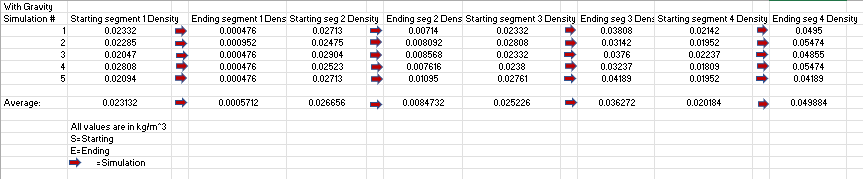

# So, we found a way to represent an ideal gas in gravity
## What did we have to sacrifice scientifically?

Firstly this simulation is sped up by 1000x in order to see the results of gravity in a reasonable time frame. I accomplished that by increasing the mass of the particles which therefore increased the gravitational pull. This does make the simulation look as if gravity pulls gas down at a rapid rate however this is not the case. 

In order to see the true speed of the interactions I must keep the original mass accurate and drastically increase the time steps. With 1e6 time steps the result appears the same as above however it takes around ~40 minutes to complete; which is theoretically more accurate although I have not found a way to quantify the accuracy difference, if any.

Also you can see that the particles no longer bounce off of the left and right walls, this is to further increase the similarties to real life. So while the box itself might be skinny the particles can travel with a positive or negative x velocity for much longer without collision which more closely resembles real life. I included this feature after looking at a similar simulation linked below.

[Here](http://www.netlogoweb.org/launch#http://ccl.northwestern.edu/netlogo/models/models/Sample%20Models/Chemistry%20&%20Physics/GasLab/GasLab%20Gravity%20Box.nlogo)


# Let's Make some conclusions 

We can see that without gravity the density of the particles in the box is essentially random. There is no trend of the particles grouping in any particular segment. 


With gravity we can see that the ideal gas has a much higher density towards the bottom segments of the box and close to no particles in the very upper segment of the box. 

#### Extra Notes:
Kg/m^3 was used for all density calculations as it seemed most popular online.
Collision detection and particle-making code is exact code from in class assignments.

### Below is the simulation with no altercations and many more time steps.

This is the most pure form of the interactions that can be simulated.
Warning this simulation will take a very long time to run.

In [ ]:
#Gravity 
m = 3.6863964e-25
FNet = vec(0,-9.8*m,0) #force of gravity

In [ ]:
scene = canvas(title = "2D representation of ideal gas affected by gravity")

m = 3.6863964e-25 #mass
k = 1.4e-23 #boltzmann constant
R = 1.52e-10 *1000#radius of atom in m *1000 to make scene more visible
T=1 #temp in kelvin 288 old
D=R*2  #diameter of atom in m
L=10*D #length of box in m
H=400*D #height of box in m
W=D+D*.1 #width of box in m
thick = L/30
s =  (np.sqrt(2*3/2*k*T/m))/10 #initial speed half of original
Volume = L*W*H #volume of box in m
partVolume = 4/3*pi*R**3  #volume of particle
segVol = Volume/4 #volume of each segment (4)

#visual objects
Lwall = box(pos = vec(-L/2,0,0), size = vec(thick,H, W), color=color.white)
Rwall = box(pos = vec(L/2,0,0), size = vec(thick,H, W), color=color.white)
Bwall = box(pos = vec(0,-H/2,0), size = vec(L,thick,W), color=color.white)
Twall = box(pos = vec(0,H/2,0), size = vec(L,thick,W), color=color.white)
Zwall = box(pos = vec(0,0,-W/2), size = vec(L,H,thick), color=color.white)

#boxes from top to bottom are in following order
#TWall
#seg1
#..
#BWall
Seg1 = box(pox = vec(0,H/4,0),size =vec(L,thick/4,W), color= color.yellow)
Seg2 = box(pox = vec(0,0,0),size =vec(L,thick/4,W), color= color.yellow)
Seg3 = box(pox = vec(0,-H/4,0),size =vec(L,thick/4,W), color= color.yellow)
print("Initial speed: ",s)
print("Volume of the box in m^3: ",Volume)
print("Volume of each segment: ",segVol,"\n")

#initialize amount of particles in each segment
seg1amount =0
seg2amount =0
seg3amount =0
seg4amount =0


N=200 #number of particles
particles = [] 

#create particles
for i in range(N):
    if i==0:
        particle = sphere(pos = vec(L/2*rand.uniform(-0.9,0.9),H/2*rand.uniform(-0.9,0.9),0), radius = R, color = color.cyan, make_trail=True, retain=20, trail_radius=0.3*R)
    else:
        particle = sphere(pos = vec(L/2*rand.uniform(-0.9,0.9),H/2*rand.uniform(-0.9,0.9),0), radius = R, color = color.red)

    #initial velocity
    particle.v = s*hat(vec(rand.uniform(-1,1), rand.uniform(-1,1), 0))
    particle.p = m*particle.v

    particles.append(particle)
    
#check for collisions and rerandomize positions of particles that are collided
collided_pairs = check_collisions()
while len(collided_pairs)!=0:
    for pair in collided_pairs:
        particles[pair[0]].pos = vec(L/2*rand.uniform(-1,1),H/2*rand.uniform(-1,1),0)
        particles[pair[1]].pos = vec(L/2*rand.uniform(-1,1),H/2*rand.uniform(-1,1),0)
        collided_pairs = check_collisions()

#time
t =0
dt = R/s/10
                                     
#Counting particles in each segment
for particle in particles:
    if particle.pos.y > H/4:
        seg1amount +=1
                                     
    elif particle.pos.y < H/4 and particle.pos.y > 0:
        seg2amount +=1

    elif particle.pos.y < 0 and particle.pos.y > -H/4:
        seg3amount +=1
                                     
    elif particle.pos.y <-H/4:
        seg4amount +=1

#output amount of particles in each segment before the simulation has started 
print("Starting amount of particles in seg 1: ",seg1amount)
print("Starting amount of particles in seg 2: ",seg2amount)
print("Starting amount of particles in seg 3: ",seg3amount)
print("Starting amount of particles in seg 4: ",seg4amount,"\n")

seg1Density = ((seg1amount*partVolume)/segVol)
seg2Density = ((seg2amount*partVolume)/segVol)
seg3Density = ((seg3amount*partVolume)/segVol)
seg4Density = ((seg4amount*partVolume)/segVol)

print("Starting density of particles in seg 1 {0:.4} in kg/m^3: ".format(seg1Density))
print("Starting density of particles in seg 2 {0:.4} in kg/m^3: ".format(seg2Density))
print("Starting density of particles in seg 3 {0:.4} in kg/m^3: ".format(seg3Density))
print("Starting density of particles in seg 4 {0:.4} in kg/m^3: ".format(seg4Density),"\n")



#evolution
scene.pause()

Nsteps = 1e6 #number of time steps for the loop
while t < Nsteps*dt:
    rate(1000) #sets number of loops per second in order to slow down or speed up visualization
    
    
    
    #update position of each particle
    for particle in particles:
#        if particle.color == color.cyan:
#            print(particle.p)
        particle.p = particle.p + (FNet*dt)
#        if particle.color == color.cyan:
#            print(particle.p)
        particle.v = particle.p/m  #check
        particle.pos = particle.pos + particle.v*dt
        
    #handle collisions of particles with each other
    collided_pairs = check_collisions()
    for pair in collided_pairs:
        i = pair[0]
        j = pair[1]
        calc_collision(i,j)
    
    #handle collision with walls
    for particle in particles:
        if particle.pos.x > L/2:
            particle.pos.x = -particle.pos.x + L/100
            #particle.v.x = - abs(particle.v.x)
            #particle.p = m*particle.v
        elif particle.pos.x < -L/2:
            particle.pos.x = -particle.pos.x - L/100
            #particle.v.x = abs(particle.v.x)
            #particle.p = m*particle.v

        if particle.pos.y > H/2:
            particle.v.y = - abs(particle.v.y)
            particle.p = m*particle.v
        elif particle.pos.y < -H/2:
            particle.v.y = abs(particle.v.y)
            particle.p = m*particle.v         
     
    t = t + dt
    
#reset the amount of particles in each segment
seg1amount =0
seg2amount =0
seg3amount =0
seg4amount =0

#Counting particles in each segment
for particle in particles:
    if particle.pos.y > H/4:
        seg1amount +=1
                                     
    elif particle.pos.y < H/4 and particle.pos.y > 0:
        seg2amount +=1

    elif particle.pos.y < 0 and particle.pos.y > -H/4:
        seg3amount +=1
                                     
    elif particle.pos.y <-H/4:
        seg4amount +=1

#output amount of particles in each segment before the simulation has started 
print("Ending amount of particles in seg 1: ",seg1amount)
print("Ending amount of particles in seg 2: ",seg2amount)
print("Ending amount of particles in seg 3: ",seg3amount)
print("Ending amount of particles in seg 4: ",seg4amount,"\n")


seg1Density = ((seg1amount*partVolume)/segVol)
seg2Density = ((seg2amount*partVolume)/segVol)
seg3Density = ((seg3amount*partVolume)/segVol)
seg4Density = ((seg4amount*partVolume)/segVol)

print("Ending density of particles in seg 1 {0:.4} in kg/m^3: ".format(seg1Density))
print("Ending density of particles in seg 2 {0:.4} in kg/m^3: ".format(seg2Density))
print("Ending density of particles in seg 3 {0:.4} in kg/m^3: ".format(seg3Density))
print("Ending density of particles in seg 4 {0:.4} in kg/m^3: ".format(seg4Density),"\n")